In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Random
using Statistics

In [2]:
?DINEOF_svds!

search: DINEOF_svds! DINEOF_svd



```
U,S,V,=DINEOF_svds!()
```

# DINEOF SVD decomposition with filling in of missing points.

# Input:

  * `X`: a two-dimensional array of size MxN with N<=M already filled in with a first guess in points with missing values
  * `missingvalues`: array of size Px2 collecting the indexes for the P missing values in location missingvalues[:,1] and missingvalues[:,2]. There is no distinction between missing values and topologically excludes points. All will be filled
  * `crossvalidation`:  array of size Qx2 collecting the indexes for the Q points to be used for cross validation
  * `keeprestart`: Boolean. If true the method keeps track of the best reconstruction up to now while doing further iterations.
  * `ncmax`: maximum number of eigenvalues calculated
  * `itstart` : defines the number of modes used during the first iteration. Then one at a time is added
  * `dineofmaxiter` : Maximum number of iterations during a SVD decomposition/filling in loop
  * `dineoftol`: Defines the tolerance below which the iterations are stopped. Relative change of xxxxx

For the other parameters, see DINEOF_svd

# Output:

  * `U,S,V`: the filled SVD decomposition such that in the infiltered version U*S*V' is the best approximation of X with nele singular vectors.
  * WARNING: X is updated at the missing data points !!!!!!


This is the basic DINEOF iterative method to find a SVD decomposition with an incomplete matrix. If you know how to prepare the data from ND to this 2D array you can work directly with this function. Otherwise use a higher level function DINEOFrun.

In [3]:
Random.seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

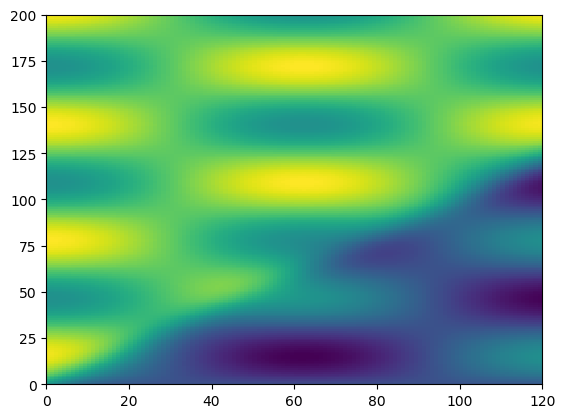

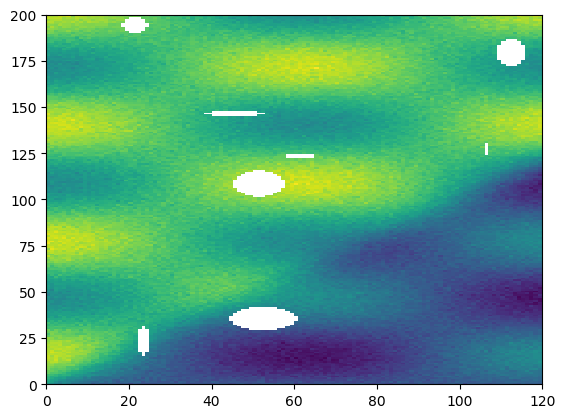

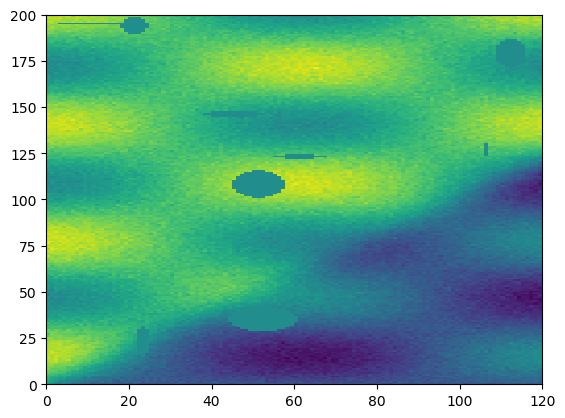

200×120 Array{Float64,2}:
 0.218735  0.0343256  -0.191273   …  -0.891053  -0.847946   -0.970491 
 0.502907  0.358108    0.0704869     -0.743091  -0.761977   -0.840981 
 0.606791  0.391246    0.325056      -0.766155  -0.580835   -0.71749  
 0.726186  0.574245    0.369344      -0.648603  -0.656046   -0.707342 
 0.819107  0.639225    0.698453      -0.642786  -0.473378   -0.65252  
 0.959583  0.907972    0.774662   …  -0.487413  -0.467832   -0.547632 
 1.27856   1.08541     1.09794       -0.282911  -0.458674   -0.524018 
 1.31328   1.30832     1.18674       -0.470059  -0.435833   -0.522744 
 1.47377   1.24595     1.17919       -0.147754  -0.0942621  -0.381302 
 1.53729   1.41452     1.30438       -0.245685  -0.347643   -0.214076 
 1.61775   1.56305     1.4014     …  -0.13713   -0.277916   -0.125948 
 1.64699   1.71849     1.55325       -0.205216  -0.0253182  -0.0201675
 1.70712   1.84101     1.87834       -0.142924  -0.106601    0.103276 
 ⋮                                ⋱                

In [4]:
NX=200
NY=120
X=zeros(Float64,NX,NY)
      for j=1:NY
            for i=1:NX
        X[i,j]=sin(i/10)*cos(j/20)+tanh((i-j)/10)
            end
        end
pcolor(X)
figure()
# use cvmask routing to create some bubbles and missing points
X=X+0.1*randn(size(X))
cvmask=DINEOF_cvmask(X,0.02,cvmethod="Bubbles",maxbubblesize=[20,20])
X[cvmask].=NaN
# Now real cv mask
cvmask=DINEOF_cvmask(X,0.05,cvmethod="Bubbles",maxbubblesize=[20,20])
pcolor(X)
NM=sum(isnan.(X))
missingvalues=zeros(Int,(NM,2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
            if isnan(X[i,j])
                icount=icount+1
                missingvalues[icount,1]=i
                missingvalues[icount,2]=j
                # Put a random value with average variance of present data so that we can keep an eye on how total variane
                # behaves.
                X[i,j]=0
            end
        end
    end
cvpoints=zeros(Int,(sum(cvmask),2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
        if  cvmask[i,j]
                icount=icount+1
                cvpoints[icount,1]=i
                cvpoints[icount,2]=j
                
            end
        end
    end
figure()
pcolor(X)
XORI=deepcopy(X)

Defaults only

In [5]:
U,S,V,cv,cva=DINEOF_svds!(X,missingvalues,cvpoints,ncmax=5)

(varmatrix, meanmatrix, varmatrixp) = (0.9752964467750473, 0.3822095334422443, 0.9996632382063266)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:75


(varchange / (size(missingvalues))[1], varmatrix) = (0.5326611536522717, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.01949160351556204, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.0011962473838548426, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (8.864197762971027e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (7.00188819243576e-6, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (5.654550083986404e-7, 0.9752964467750473)
(iloop, varchange) = (1, 0.0003307911799132046)
cvval = 423.04256162216944
(iloop, cvbest) = (1, 423.04256162216944)
(svdmeth, filter, filterin

┌ Warning: Strange
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:268
┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.143630041227821
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:274


(M, N, musquare) = (200, 120, 0.1)
"ended" = "ended"
(size(missingvalues), size(U), size(V), size(S), N, M, NE) = ((585, 2), (200, 5), (120, 5), (5,), 120, 200, 5)


([-0.08280609093094538 -0.011967561355372622 … 0.03381999905400288 -0.10165558094868754; -0.08330875883394014 -0.0005198297017386944 … 0.039635378770060015 -0.07229964527110998; … ; 0.05793936697732087 0.08710121479733025 … -0.0032065930562656638 0.08645304776215126; 0.05617751751417323 0.08754912290797688 … -0.0069161333685504554 0.05900826476368676], [125.55569094460516, 78.06019708012425, 69.67554025065267, 20.717018507726415, 9.55977389156763], [0.02536306515570277 0.2072647045021714 … 0.13740139842904603 -0.18157988461684121; 0.025533202427860693 0.20483543001521273 … 0.14584985094932137 -0.17305867747124562; … ; 0.026800835852886243 0.005181699278719223 … -0.15168589733478133 -0.06383568074916202; 0.026089364585637497 0.010254260116222193 … -0.16215557125529484 -0.03980368180655511], 0.09670304573677677, [0.3560964323418935, 0.4976009010321714, 0.18794475397331778, 0.10990662078307617, 0.09670304573677677], [0.16220971292654843 0.16220971292654843 … 0.16220971292654843 0.16220971

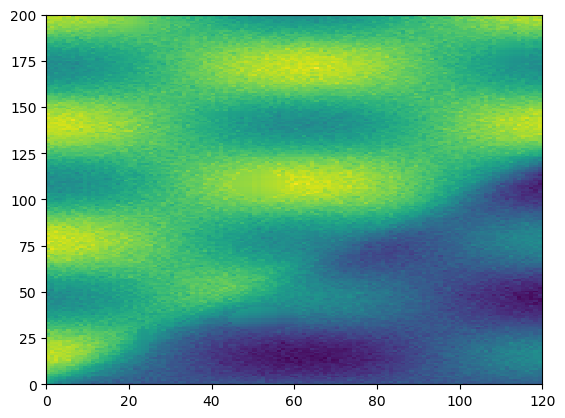

PyObject <matplotlib.collections.PolyCollection object at 0x00000000381BB6A0>

In [6]:
pcolor(X)

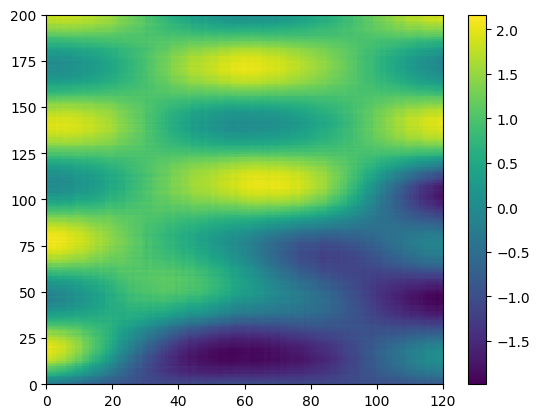

(PyObject <matplotlib.collections.PolyCollection object at 0x0000000034B98390>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000036C7C160>)

In [7]:

pcolor(U*diagm(S)*V'),colorbar()

In [8]:
X=deepcopy(XORI)

200×120 Array{Float64,2}:
 0.218735  0.0343256  -0.191273   …  -0.891053  -0.847946   -0.970491 
 0.502907  0.358108    0.0704869     -0.743091  -0.761977   -0.840981 
 0.606791  0.391246    0.325056      -0.766155  -0.580835   -0.71749  
 0.726186  0.574245    0.369344      -0.648603  -0.656046   -0.707342 
 0.819107  0.639225    0.698453      -0.642786  -0.473378   -0.65252  
 0.959583  0.907972    0.774662   …  -0.487413  -0.467832   -0.547632 
 1.27856   1.08541     1.09794       -0.282911  -0.458674   -0.524018 
 1.31328   1.30832     1.18674       -0.470059  -0.435833   -0.522744 
 1.47377   1.24595     1.17919       -0.147754  -0.0942621  -0.381302 
 1.53729   1.41452     1.30438       -0.245685  -0.347643   -0.214076 
 1.61775   1.56305     1.4014     …  -0.13713   -0.277916   -0.125948 
 1.64699   1.71849     1.55325       -0.205216  -0.0253182  -0.0201675
 1.70712   1.84101     1.87834       -0.142924  -0.106601    0.103276 
 ⋮                                ⋱                

In [9]:
X=deepcopy(XORI)
@time U,S,V,cv,cva=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5,filter="pmf",filterrepetitions=5)

(varmatrix, meanmatrix, varmatrixp) = (0.9752964467750473, 0.3822095334422443, 0.9996632382063266)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:75


(varchange / (size(missingvalues))[1], varmatrix) = (0.5366663397485532, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.01870776304118188, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.0011444834830658444, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (8.325536709439758e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (6.372908513735193e-6, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (4.961577623006438e-7, 0.9752964467750473)
(iloop, varchange) = (1, 0.0002902522909458766)
cvval = 420.9995336980946
(iloop, cvbest) = (1, 420.9995336980946)
(svdmeth, filter, filterintensit

┌ Warning: Strange
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:268
┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.1407479389688173
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:274


  1.952142 seconds (1.34 M allocations: 319.632 MiB, 3.59% gc time)


([0.08290223691217413 -0.011462226294389005 … -0.03325435711812066 -0.09718820940195316; 0.0833617325173687 -0.0001266586324625285 … -0.039236159817279306 -0.07015439139942058; … ; -0.05827704389908631 0.08588346952599907 … 0.0036500510381998453 0.08910095693734993; -0.05652749662906831 0.08624107293573696 … 0.006585589886821373 0.060001180527938736], [125.4567619478878, 77.91756206156863, 69.50711815237186, 20.52439333147928, 9.320366675941532], [-0.026037142446437747 0.20544440554922244 … -0.139317003878777 -0.1710192325142603; -0.026381993569591457 0.20486477136591544 … -0.13698895425267962 -0.16635968007331947; … ; -0.028267456026276006 0.004420415530368935 … 0.15175602694937226 -0.06794839270346334; -0.02741290904828266 0.00514101174930408 … 0.1555238937128168 -0.0657142081548477], 0.09266035217551882, [0.35437671186708297, 0.4957256724920097, 0.1848930713766812, 0.10681131190616173, 0.09266035217551882], [0.16109884975959646 0.16109884975959646 … 0.16109884975959646 0.16109884975

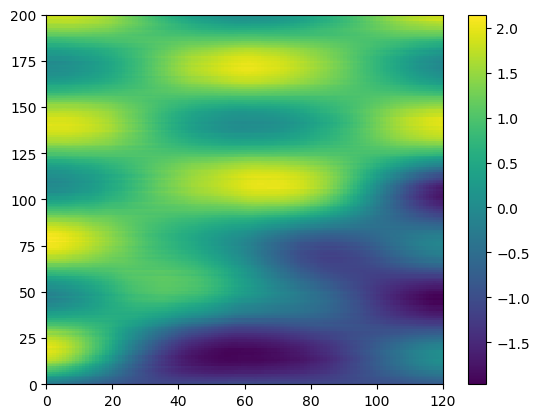

(PyObject <matplotlib.collections.PolyCollection object at 0x0000000036E2B358>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003E3EA128>)

In [10]:
pcolor(U*diagm(S)*V'),colorbar()

In [11]:
X=deepcopy(XORI)
@time U,S,V,cv,cva=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5,filter="pmf",svdtol=0.0001,filterrepetitions=5)

(varmatrix, meanmatrix, varmatrixp) = (0.9752964467750473, 0.3822095334422443, 0.9996632382063266)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.536666339748553, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:75


(varchange / (size(missingvalues))[1], varmatrix) = (0.018707763041181897, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.0011444834830658523, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (8.32553670943958e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (6.372908513736604e-6, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (4.961577623003095e-7, 0.9752964467750473)
(iloop, varchange) = (1, 0.000290252290945681)
cvval = 420.9995336980946
(iloop, cvbest) = (1, 420.9995336980946)
(svdmeth, filter, filterintensity) = ("svd", "pmf", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.0686752461517781, 0.9752964467750473)
(svdmeth, filter, filterintensity

┌ Warning: Strange
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:268
┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.1407479389688169
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:274


([0.08290223691217413 -0.011462226294388908 … 0.0332543571181205 -0.09718820940195236; 0.08336173251736871 -0.00012665863246275055 … 0.03923615981727916 -0.0701543913994192; … ; -0.05827704389908631 0.08588346952599898 … -0.0036500510381999077 0.08910095693735007; -0.05652749662906828 0.08624107293573686 … -0.006585589886821289 0.060001180527938965], [125.45676194788778, 77.91756206156859, 69.50711815237183, 20.524393331479263, 9.320366675941528], [-0.026037142446437737 0.20544440554922208 … 0.1393170038787759 -0.1710192325142611; -0.026381993569591478 0.20486477136591533 … 0.13698895425267932 -0.1663596800733197; … ; -0.028267456026275867 0.00442041553036867 … -0.15175602694937235 -0.06794839270346423; -0.027412909048282613 0.005141011749303837 … -0.15552389371281627 -0.06571420815485018], 0.09266035217551853, [0.35437671186708297, 0.49572567249200944, 0.18489307137668096, 0.10681131190616149, 0.09266035217551853], [0.16109884975959635 0.16109884975959635 … 0.16109884975959635 0.16109

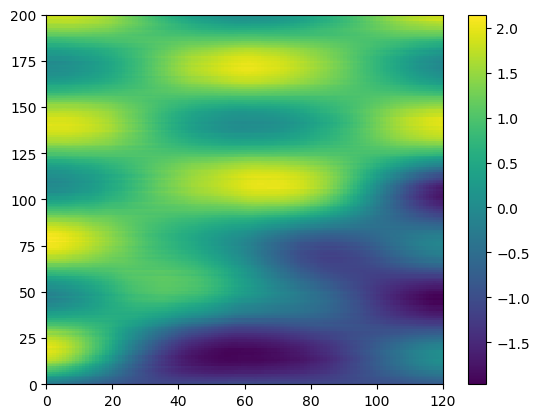

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003E59E6A0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003F27B390>)

In [12]:
pcolor(U*diagm(S)*V'),colorbar()

In [13]:
cva

5-element Array{Float64,1}:
 0.35437671186708297
 0.49572567249200944
 0.18489307137668096
 0.10681131190616149
 0.09266035217551853

In [14]:
X=deepcopy(XORI)
@time U,S,V,cv,cva=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5)

(varmatrix, meanmatrix, varmatrixp) = (0.9752964467750473, 0.3822095334422443, 0.9996632382063266)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.5326611536522716, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.019491603515561957, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.0011962473838548714, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (8.864197762972154e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (7.001888192433739e-6, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (5.654550083984975e-7, 0.97

┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:75


(varchange / (size(missingvalues))[1], varmatrix) = (0.00012524980836344302, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (5.946008019188664e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (2.9186480899082496e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (1.4524236005904071e-5, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (7.268419670219767e-6, 0.9752964467750473)
cvval = 223.27836772030145
(iloop, cvbest) = (3, 223.27836772030145)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchange / (size(missingvalues))[1], varmatrix) = (0.006210511112738154, 0.9752964467750473)
(svdmeth, filter, filterintensity) = ("svd", "None", 1.0)
(varchang

┌ Warning: Strange
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:268
┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.143630041227821
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:274


([0.08280609093094538 0.011967561355372663 … -0.03381999905400304 -0.10165558094868746; 0.0833087588339401 0.0005198297017386944 … -0.03963537877006001 -0.07229964527110992; … ; -0.057939366977320834 -0.08710121479733025 … 0.003206593056265636 0.08645304776215143; -0.05617751751417319 -0.08754912290797688 … 0.006916133368550377 0.05900826476368682], [125.55569094460516, 78.06019708012424, 69.67554025065266, 20.71701850772642, 9.559773891567627], [-0.02536306515570276 -0.20726470450217135 … -0.1374013984290459 -0.18157988461684105; -0.025533202427860707 -0.20483543001521265 … -0.1458498509493216 -0.1730586774712455; … ; -0.026800835852886153 -0.005181699278719278 … 0.15168589733478177 -0.06383568074916245; -0.02608936458563734 -0.0102542601162222 … 0.16215557125529523 -0.039803681806556385], 0.09670304573677652, [0.35609643234189325, 0.49760090103217064, 0.18794475397331772, 0.10990662078307623, 0.09670304573677652], [0.16220971292654854 0.16220971292654854 … 0.16220971292654854 0.16220

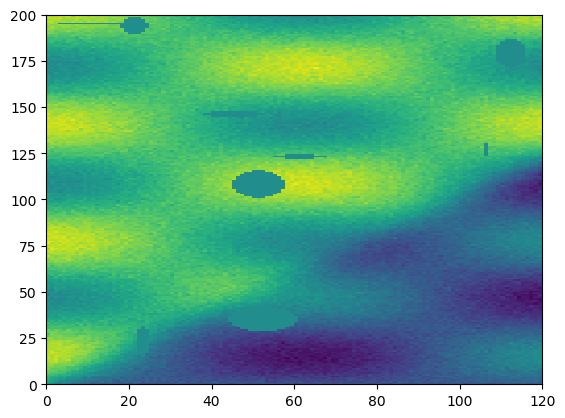

PyObject <matplotlib.collections.PolyCollection object at 0x000000003F42C978>

In [15]:
pcolor(XORI)

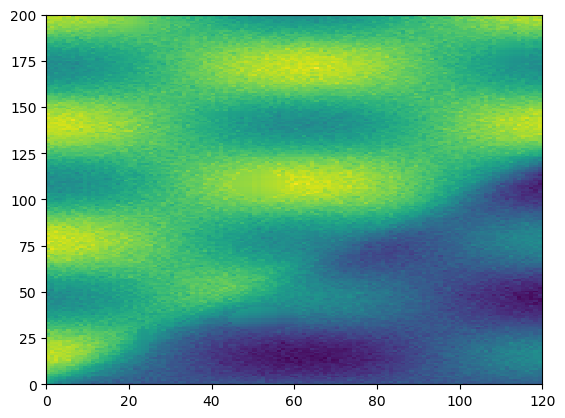

PyObject <matplotlib.collections.PolyCollection object at 0x00000000410C5F60>

In [16]:
pcolor(X)